In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
df_train_label=pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
df_train_label.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [2]:
# path of the files
paths_files = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")

In [3]:
ids=[]
for filext in paths_files:
    ids.append(filext[filext.rindex('/')+1:\
                              len(filext)].replace('.npy',''))
    
# data frame containing paths and ids of .npy files 
path_df = pd.DataFrame({"id":ids,"path":paths_files})
path_df.head()

,id,path
0,777d746e90,../input/g2net-gravitational-wave-detection/tr...
1,777ecfbd65,../input/g2net-gravitational-wave-detection/tr...
2,7770956992,../input/g2net-gravitational-wave-detection/tr...
3,77727f6826,../input/g2net-gravitational-wave-detection/tr...
4,777c84c377,../input/g2net-gravitational-wave-detection/tr...


In [4]:
df=pd.merge(path_df,df_train_label,on='id')
del path_df, df_train_label;
df.head()

,id,path,target
0,777d746e90,../input/g2net-gravitational-wave-detection/tr...,1
1,777ecfbd65,../input/g2net-gravitational-wave-detection/tr...,0
2,7770956992,../input/g2net-gravitational-wave-detection/tr...,1
3,77727f6826,../input/g2net-gravitational-wave-detection/tr...,1
4,777c84c377,../input/g2net-gravitational-wave-detection/tr...,0


In [5]:
df=pd.concat([df[df['target']==1][['id','path','target']].sample(n=60000, random_state=0),\
          df[df['target']==0][['id','path','target']].sample(n=60000, random_state=0)]).sample(frac=1,random_state=0)
df.head()

,id,path,target
77782,bf1eb07f55,../input/g2net-gravitational-wave-detection/tr...,1
172727,5de5b4f546,../input/g2net-gravitational-wave-detection/tr...,0
178138,e298b9db82,../input/g2net-gravitational-wave-detection/tr...,1
443182,4113573643,../input/g2net-gravitational-wave-detection/tr...,0
477845,910a7c72a5,../input/g2net-gravitational-wave-detection/tr...,1


In [6]:
# Loading the first .npy data
data=np.load(df[df['target']==1]['path'].iloc[3])
data

array([[-1.41661371e-21, -1.36443280e-21, -1.20573412e-21, ...,
         7.83671606e-22,  8.61849573e-22,  1.41773124e-21],
       [ 9.17605406e-21,  9.05680029e-21,  8.97858006e-21, ...,
         5.69838810e-21,  5.46298374e-21,  5.31875627e-21],
       [-1.52049803e-21, -1.51722241e-21, -1.54984733e-21, ...,
         3.22881317e-22,  4.46477098e-22,  1.80836016e-22]])

In [7]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.applications import ResNet50

#### More about the CWT can be found in the following Kaggle Notebook [here](https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer)

In [8]:
%%writefile tf_cwt.py
# Based on Alexander Neergaard Olesen's CWT Python implementation. https://github.com/neergaard/CWT
# Adapted to Keras by Geir Drange
# MIT License

import tensorflow as tf
from tensorflow import keras
import tensorflow.experimental.numpy as tnp
import numpy as np
import math

# calculate CWT of input signal
class Wavelet1D(keras.layers.Layer):
    def __init__(self, nv=12, sr=1., flow=0., fhigh=0.5, batch_size=None, trainable=False):
        super(Wavelet1D, self).__init__()
        assert fhigh > flow, 'fhigh parameters must be > flow!'
        assert batch_size != None, 'batch size must be set!'
        
        self.batch_size = batch_size 
        self.nv = nv # number of voices
        self.sr = sr # sample rate (Hz)
        self.flow = flow # lowest frequency of interest (Hz)
        self.fhigh = fhigh # highest frequency of interest (Hz)
        self.trainable = trainable # True to train the wavelet filter bank

    def build(self, input_shape):
        assert len(input_shape) == 2,\
        'Input dimension must be 2! Dimension is {}'.format(len(input_shape))
        
        max_scale = input_shape[-1] // (np.sqrt(2) * 2)
        if max_scale <= 1:
            max_scale = input_shape[-1] // 2
        max_scale = np.floor(self.nv * np.log2(max_scale))
        scales = 2 * (2**(1/self.nv)) ** np.arange(0, max_scale + 1)
        frequencies = self.sr * (6 / (2 * np.pi)) / scales
        frequencies = frequencies[frequencies >= self.flow] # remove low frequencies
        scales = scales[0:len(frequencies)]
        frequencies = frequencies[frequencies <= self.fhigh] # remove high frequencies
        scales = scales[len(scales)-len(frequencies):len(scales)]
        # wavft
        padvalue = input_shape[-1] // 2
        n = padvalue*2+input_shape[-1]
        omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
        omega = omega*(2 * np.pi) / n
        omega = np.concatenate((np.array([0]), omega, -omega[\
                                                             np.arange(math.floor((n - 1) / 2),\
                                                                       0, -1, dtype=int) - 1]))
        _wft = np.zeros([scales.size, omega.size])
        for jj, scale in enumerate(scales):
            expnt = -(scale * omega - 6) ** 2 / 2 * (omega > 0)
            _wft[jj, ] = 2 * np.exp(expnt) * (omega > 0)
        # parameters we want to use during call():
        self.wft = tf.Variable(_wft, trainable=self.trainable) # yes, the wavelets can be trainable if desired
        self.padvalue = padvalue
        self.num_scales = scales.shape[-1]
    
    # uses a loop - better to vectorize (TODO)
    def call(self, inputs):
        max_loop = tf.shape(inputs)[0]
        
        def sum_cwt(i, pre_data):
            next_data = tf.nn.embedding_lookup(inputs, i) 
            x = tf.concat([tf.reverse(next_data[0:self.padvalue], axis=[0]),\
                           next_data, tf.reverse(next_data[-self.padvalue:], axis=[0])], 0)
            f = tf.signal.fft(tf.cast(x, tf.complex64))
            cwtcfs = tf.signal.ifft(tnp.kron(tf.ones([self.num_scales, 1],\
                                                     dtype=tf.complex64)\
                                             , f) * tf.cast(self.wft, tf.complex64))
            logcwt = tf.math.log(tf.math.abs(cwtcfs[:,\
                                                    self.padvalue:self.padvalue + next_data.shape[-1]]))
            pre_data = tf.tensor_scatter_nd_add(pre_data, indices=[[i]], updates=[logcwt])
            i_next = i + 1
            return i_next, pre_data
                                 
        _, cwt = tf.while_loop(cond = lambda i, result: tf.less(i, max_loop),
                              body = sum_cwt,
                              loop_vars = (tf.constant(0, dtype=tf.int32),\
                                           tf.zeros([self.batch_size, self.num_scales,\
                                                     inputs.shape[-1]], dtype = tf.float32)))
        return cwt
    
# scale input to range 0.0 - upper
class Scaler(keras.layers.Layer):
    def __init__(self, upper=1.0):
        super(Scaler, self).__init__()
        self.upper = tf.cast(upper, dtype=tf.float32) # upper value (typically 1.0 or 255.0 for image CNNs)
    
    def call(self, inputs):
        min_val = tf.math.reduce_min(inputs)
        max_val = tf.math.reduce_max(tf.math.subtract(inputs, min_val))
        return tf.math.multiply(tf.math.subtract(inputs, min_val), self.upper/max_val)
    
# Stack three channels into RGB image
class RGBStack(keras.layers.Layer):
    def __init__(self):
        super(RGBStack, self).__init__()
        
    def call(self, inputs):
        return tf.stack(inputs, axis = 3)

Writing tf_cwt.py


In [9]:
from tf_cwt import Wavelet1D, Scaler, RGBStack

#### Look into scaleogram

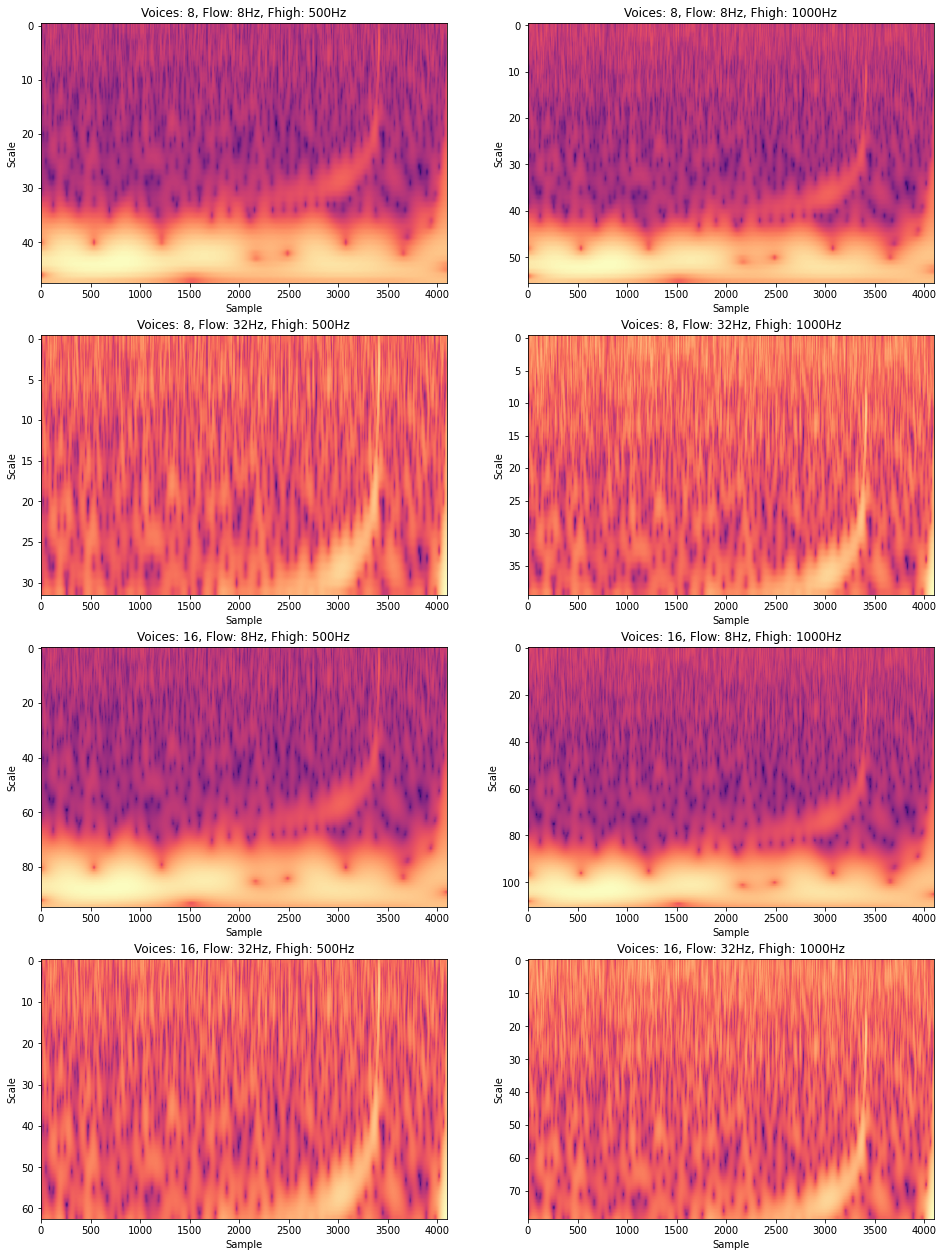

In [10]:
fig = plt.figure(figsize=(16,22))
idx = 0
for nv in [8,16]:
    for flow in [8,32]:
        for fhigh in [500, 1000]:
            y = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=1)\
            (tf.expand_dims(data[0,:], axis=0))
            y = Scaler(upper=1)(y)
            ax = plt.subplot(4, 2, 1+idx)
            plt.xlabel('Sample')
            plt.ylabel('Scale')
            plt.title('Voices: {}, Flow: {}Hz, Fhigh: {}Hz'.format(nv, flow, fhigh))
            plt.imshow(np.squeeze(y.numpy()), cmap='magma', aspect='auto') 
            idx += 1

In [11]:
data[0,:]

array([-1.41661371e-21, -1.36443280e-21, -1.20573412e-21, ...,
        7.83671606e-22,  8.61849573e-22,  1.41773124e-21])

### Downsampling
The scaleogram has the same width as the input signal. This needs to be reduced to our target image size (here we choose 224). Rather than doing an image resize type operation, we can use several types of layers:

1. Max pooling
2. Average pooling
3. 2D convolution (this can also be trained!)
The trick is to set the pool/filter size to (1,n), where n is the reduction factor, and stride to the same size. Let's try it out:

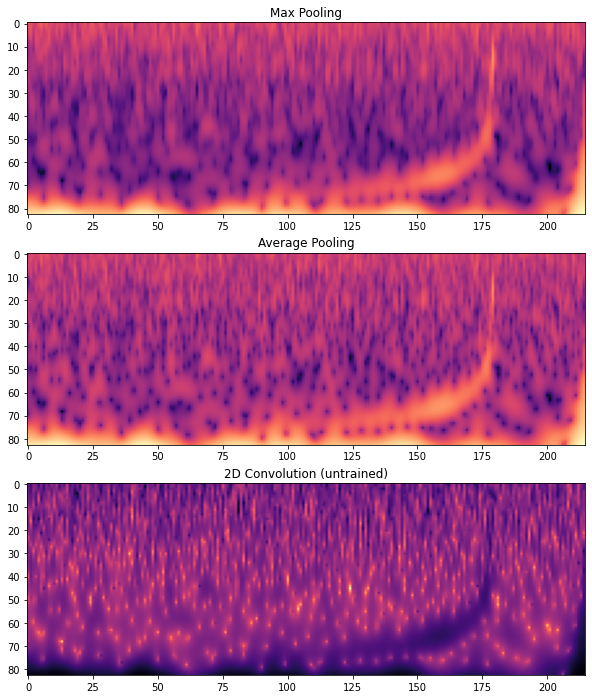

In [12]:
TARGET_IMG_SIZE = 224
STRIDE = int(np.ceil(4096/TARGET_IMG_SIZE))

y1 = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(data[0,:], axis=0))
y1 = Scaler(upper=1)(y1)
y1 = tf.reshape(y1, [y1.shape[0],y1.shape[1],y1.shape[2],1])
fig = plt.figure(figsize=(10,12))
ax = plt.subplot(3, 1, 1)
y2a = MaxPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2a = Scaler(upper=1)(y2a)
plt.title('Max Pooling')
plt.imshow(tf.reshape(y2a, [y2a.shape[1],y2a.shape[2]]).numpy(), cmap='magma', aspect='auto')
ax = plt.subplot(3, 1, 2)
y2b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2b = Scaler(upper=1)(y2b)
plt.title('Average Pooling')
plt.imshow(tf.reshape(y2b, [y2b.shape[1],y2b.shape[2]]).numpy(), cmap='magma', aspect='auto') 
ax = plt.subplot(3, 1, 3)
y2c = Conv2D(filters=1, kernel_size=(1,STRIDE), strides=(1,STRIDE))(y1)
y2c = Scaler(upper=1)(y2c)
plt.title('2D Convolution (untrained)')
plt.imshow(tf.reshape(y2c, [y2c.shape[1],y2c.shape[2]]).numpy(), cmap='magma', aspect='auto');

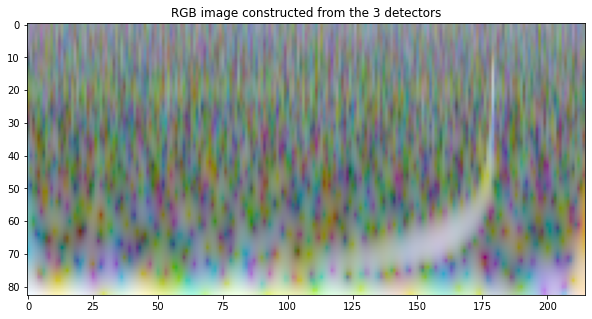

In [13]:
r = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(data[0,:], axis=0))
r = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(r, [r.shape[0],r.shape[1],r.shape[2],1]))
r = Scaler(upper=1)(r)
r = tf.reshape(r, [r.shape[1],r.shape[2]])
g = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(data[1,:], axis=0))
g = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(g, [g.shape[0],g.shape[1],g.shape[2],1]))
g = Scaler(upper=1)(g)
g = tf.reshape(g, [g.shape[1],g.shape[2]])
b = Wavelet1D(nv=16, sr=2048., flow=20, fhigh=750, batch_size=1)(tf.expand_dims(data[2,:], axis=0))
b = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(tf.reshape(b, [b.shape[0],b.shape[1],b.shape[2],1]))
b = Scaler(upper=1)(b)
b = tf.reshape(b, [b.shape[1],b.shape[2]])
rgb = tf.stack([r, g, b], axis = 2)
fig = plt.figure(figsize=(10,5))
plt.title('RGB image constructed from the 3 detectors')
plt.imshow(rgb.numpy(), cmap='magma', aspect='auto');


In [14]:
from sklearn.model_selection import train_test_split
df_train, df_val= train_test_split(df, test_size=0.2, random_state=0)

In [15]:
def npy_header_offset(npy_path):
    with open(str(npy_path), 'rb') as f:
        if f.read(6) != b'\x93NUMPY':
            raise ValueError('Invalid NPY file.')
        version_major, version_minor = f.read(2)
        if version_major == 1:
            header_len_size = 2
        elif version_major == 2:
            header_len_size = 4
        else:
            raise ValueError('Unknown NPY file version {}.{}.'.format(version_major, version_minor))
        header_len = sum(b << (8 * i) for i, b in enumerate(f.read(header_len_size)))
        header = f.read(header_len)
        if not header.endswith(b'\n'):
            raise ValueError('Invalid NPY file.')
        return f.tell()

In [16]:
header_size = npy_header_offset(df['path'].iloc[0])
header_size

128

In [17]:
tf_data_train=tf.data.FixedLengthRecordDataset( df_train['path'], 3*4096*tf.float64.size,\
                                         header_bytes=header_size, num_parallel_reads=526)
tf_data_val=tf.data.FixedLengthRecordDataset( df_val['path'], 3*4096*tf.float64.size,\
                                         header_bytes=header_size, num_parallel_reads=526)
tf_data_train = tf_data_train.map(lambda s: tf.reshape(\
                                                       tf.io.decode_raw(s, tf.float64),\
                                                       (3,4096)))
tf_data_val = tf_data_val.map(lambda s: tf.reshape(\
                                                       tf.io.decode_raw(s, tf.float64),\
                                                       (3,4096)))
tf_data_train

<MapDataset shapes: (3, 4096), types: tf.float64>

In [18]:
tf_data_train= tf.data.Dataset.zip((tf_data_train,\
                             tf.data.Dataset.from_tensor_slices(df_train['target'])))
tf_data_val= tf.data.Dataset.zip((tf_data_val,\
                             tf.data.Dataset.from_tensor_slices(df_val['target']))) 

In [19]:
BATCH_SIZE=64
train_data = tf_data_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf_data_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_data

<PrefetchDataset shapes: ((None, 3, 4096), (None,)), types: (tf.float64, tf.int64)>

### CWT to image model

In [20]:
TARGET_IMG_SIZE = 224 # image size expected by the CNN model
# skip start to make img_size integer multiple of 4096
OFFSET = 4096-int(np.floor(4096/224))*TARGET_IMG_SIZE
STRIDE = (4096-OFFSET)//TARGET_IMG_SIZE

# CTW model
def build_cwt_model(nv=16, flow=20, fhigh=10000, batch_size=64):
    inputs = Input(shape=(3, 4096))
    # channels
    r = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,0,OFFSET:])  
    g = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,1,OFFSET:]) 
    b = Wavelet1D(nv=nv, sr=2048., flow=flow, fhigh=fhigh, batch_size=batch_size)(inputs[:,2, OFFSET:]) 
    # combine into rgb
    rgb = RGBStack()([r, g, b])
    # downsample
    rgb = AvgPool2D(pool_size=(1,STRIDE), strides=(1,STRIDE))(rgb) 
    rgb = Scaler(upper=255.)(rgb) # adjust 'upper' according to CNN 
    
    return tf.keras.Model(inputs, rgb, name="Wavlet")
    
cwt_model = build_cwt_model(batch_size=BATCH_SIZE)
cwt_model.summary()

Model: "Wavlet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 4096)]    0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 4032)         0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 4032)         0           input_1[0][0]                    
_____________________________________________________________________________________________

In [21]:
resnet=ResNet50(weights = 'imagenet', input_shape = (90, 224, 3), include_top = False)

94773248/94765736 [==============================] - 1s 0us/step


In [22]:
for l in resnet.layers:
    l.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90, 224, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 96, 230, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 45, 112, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 45, 112, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
new_model=Sequential()
new_model.add(cwt_model)
new_model.add(resnet)
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Wavlet (Functional)          (64, 90, 224, 3)          2177280   
_________________________________________________________________
resnet50 (Functional)        (None, 3, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (64, 43008)               0         
_________________________________________________________________
dense (Dense)                (64, 128)                 5505152   
_________________________________________________________________
dense_1 (Dense)              (64, 64)                  8256      
_________________________________________________________________
dense_2 (Dense)              (64, 32)                  2080      
_________________________________________________________________
dense_3 (Dense)              (64, 1)                   3

In [24]:
new_model.compile(optimizer = Adam(lr=1e-3),loss='binary_crossentropy',metrics=['AUC'])
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Wavlet (Functional)          (64, 90, 224, 3)          2177280   
_________________________________________________________________
resnet50 (Functional)        (None, 3, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (64, 43008)               0         
_________________________________________________________________
dense (Dense)                (64, 128)                 5505152   
_________________________________________________________________
dense_1 (Dense)              (64, 64)                  8256      
_________________________________________________________________
dense_2 (Dense)              (64, 32)                  2080      
_________________________________________________________________
dense_3 (Dense)              (64, 1)                   3

In [ ]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.01), cooldown=0,\
                               patience=3, min_lr=0.5e-8,mode='min')
# This file path where the best weights will be saved
checkpoint_filepath = './CWT_weights7.best.hdf5'
# It saves the weights which shows the highest validation accuracy
modelchck=ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,verbose=1,
                          monitor='val_auc',mode='max',save_best_only=True)

new_model.fit(train_data, validation_data=val_data, epochs = 10,\
              callbacks=[lr_reducer,modelchck])

In [26]:
# The model weights (that are considered the best) are loaded into the model.
checkpoint_filepath = '../input/cwt-best-weights-1/CWT_weights7.best.hdf5'
new_model.load_weights(checkpoint_filepath)

In [27]:
# path of the files
test_files = glob("../input/g2net-gravitational-wave-detection/test/*/*/*/*")
#paths_files
ids=[]
for filext in test_files:
    ids.append(filext[filext.rindex('/')+1:\
                              len(filext)].replace('.npy',''))
    
# data frame containing paths and ids of .npy files 
test_df = pd.DataFrame({"id":ids,"path":test_files})
test_df.head()

,id,path
0,77771b0d0b,../input/g2net-gravitational-wave-detection/te...
1,7776d72ecd,../input/g2net-gravitational-wave-detection/te...
2,777bab6bb5,../input/g2net-gravitational-wave-detection/te...
3,7776fc12d4,../input/g2net-gravitational-wave-detection/te...
4,77743dcab1,../input/g2net-gravitational-wave-detection/te...


In [28]:
tf_data_test=tf.data.FixedLengthRecordDataset( test_df['path'], 3*4096*tf.float64.size,\
                                         header_bytes=header_size, num_parallel_reads=4)
tf_data_test = tf_data_test.map(lambda s: tf.reshape(\
                                                       tf.io.decode_raw(s, tf.float64),\
                                                       (3,4096)))
test_data = tf_data_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [29]:
y_pred=new_model.predict(test_data)
y_pred

array([[0.4121768 ],
       [0.4371175 ],
       [0.41425487],
       ...,
       [0.9995666 ],
       [0.9995666 ],
       [0.9995666 ]], dtype=float32)

In [38]:
print(y_pred.shape,test_df.shape)

(226048, 1) (226000, 2)


In [44]:
y_pred[0:226000].flatten()

array([0.4121768 , 0.4371175 , 0.41425487, ..., 0.97467196, 0.41244385,
       0.38124624], dtype=float32)

In [45]:

output = pd.DataFrame({'Id': test_df.id, 'target': y_pred[0:226000].flatten()})
output.head()

,Id,target
0,77771b0d0b,0.412177
1,7776d72ecd,0.437117
2,777bab6bb5,0.414255
3,7776fc12d4,0.589581
4,77743dcab1,0.551803


In [46]:
output.to_csv('./CWT_small_batch.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
